# Eventos de temperatura extrema em Porto Alegre

Neste exemplo vamos:

- Utilizar uma `API` pública para obter dados climáticos de Porto Alegre.

- Utilizar `pandas`, `numpy` e `scipy` para calcular a frequência de eventos de temperatura extrema.

- Utilizar `matplotlib` para fazer gráficos que nos ajudarão na análise dos dados.

A [Open-Meteo](https://open-meteo.com/) é uma `API` de código aberto sobre histórico e previsão de dados climáticos em qualquer localização do planeta. Vamos utilizá-la para obter a temperatura máxima por dia, nos últimos 20 anos, em Porto Alegre 

In [1]:
import requests

url = "https://archive-api.open-meteo.com/v1/archive"
params = {
    "latitude": -30.0331,
    "longitude": -51.23,
    "start_date": "2004-01-01",
    "end_date": "2024-12-31",
    "daily": ["temperature_2m_max"],
    "timezone": "America/Sao_Paulo"
}

response = requests.get(url, params=params)

In [ ]:
import pandas as pd

df = pd.DataFrame(response.json()["daily"])
df["time"] = pd.to_datetime(df["time"])
df.rename(columns={"temperature_2m_max": "temp_max"}, inplace=True)
df

,time,temp_max
0,2004-01-01,21.9
1,2004-01-02,25.0
2,2004-01-03,27.1
3,2004-01-04,28.6
4,2004-01-05,30.7
...,...,...
7666,2024-12-27,27.8
7667,2024-12-28,26.1
7668,2024-12-29,26.3
7669,2024-12-30,27.4


In [34]:
df["month_day"] = df["time"].apply(lambda x: x.strftime("%m-%d"))
df["month_day"]

0       01-01
1       01-02
2       01-03
3       01-04
4       01-05
        ...  
7666    12-27
7667    12-28
7668    12-29
7669    12-30
7670    12-31
Name: month_day, Length: 7671, dtype: object

In [55]:
from scipy.ndimage import gaussian_filter1d

temp_day = df.groupby("month_day")[["temp_max"]].mean()
temp_day.rename(columns={"temp_max": "mean"}, inplace=True)
temp_day["std"] = df.groupby("month_day")[["temp_max"]].std()

temp_day["mean_smooth"] = gaussian_filter1d(temp_day["mean"], sigma=5)

temp_day

,mean,std,mean_smooth
month_day,,,
01-01,29.842857,3.515618,29.516699
01-02,28.847619,3.809937,29.539840
01-03,28.490476,3.426063,29.583636
01-04,28.923810,2.644599,29.643364
01-05,29.461905,1.992354,29.712514
...,...,...,...
12-27,29.309524,3.539195,29.610150
12-28,29.761905,3.741186,29.671121
12-29,30.071429,3.171300,29.721100


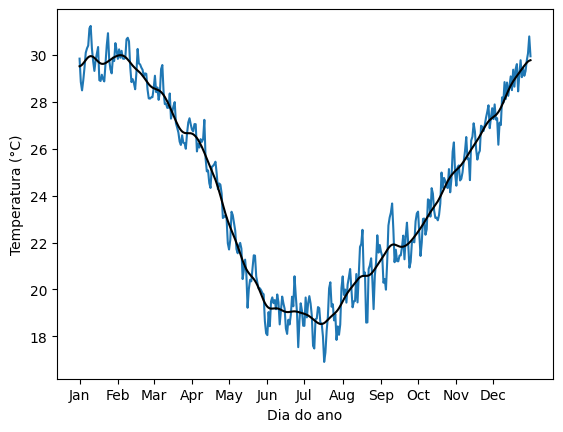

In [60]:
import matplotlib.pyplot as plt
import calendar

x_ticks = []
x_labels = []
for idx, month_day in enumerate(temp_day.index):
    month, day = [int(y)  for y in month_day.split("-")]
    if day == 1:
        x_ticks.append(idx)
        x_labels.append(calendar.month_abbr[month])

plt.xticks(ticks=x_ticks, labels=x_labels)
plt.xlabel("Dia do ano")
plt.ylabel("Temperatura (°C)")

plt.plot(temp_day.index, temp_day["mean"])
plt.plot(temp_day.index, gaussian_filter1d(temp_day["mean"], sigma=5), c="black")

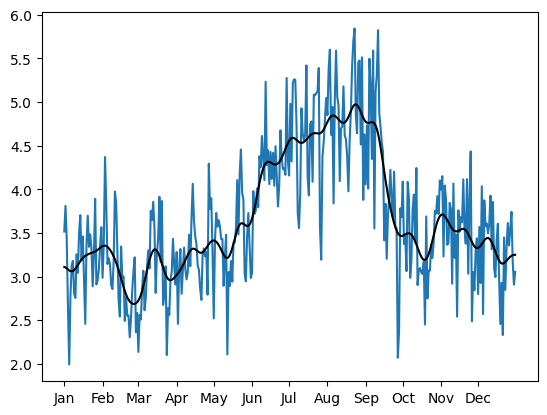

In [140]:
temp_day["std_smooth"] = gaussian_filter1d(temp_day["std"], sigma=5)

plt.xticks(ticks=x_ticks, labels=x_labels)

plt.plot(temp_day["std"])
plt.plot(temp_day["std_smooth"], c="black")

In [153]:
import numpy as np

def extreme_event(df: pd.DataFrame, temp_day: pd.DataFrame, n, k):
    all_mean = df["month_day"].map(temp_day["mean_smooth"])
    all_std = df["month_day"].map(temp_day["std_smooth"])

    above = df["temp_max"] > all_mean + k * all_std

    kernel = np.full(n, 1)

    return np.convolve(above, kernel)[n-1:] == n 

df["extreme"] = extreme_event(df, temp_day, n=4, k=1)

In [154]:
df["ano"] = df["time"].apply(lambda x: x.year)

extreme_year = df.groupby("ano")[["extreme"]].sum()
extreme_year

,extreme
ano,
2004,6
2005,14
2006,10
2007,13
2008,6
2009,13
2010,1
2011,0
2012,29


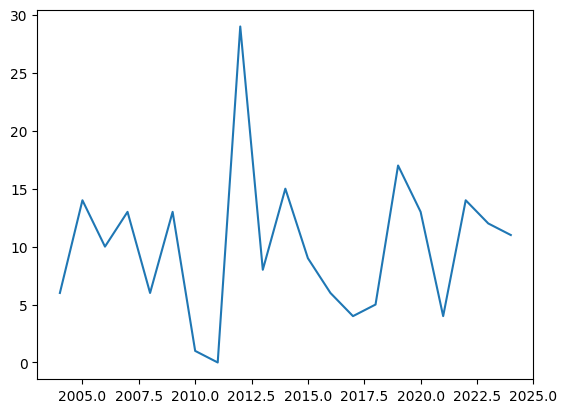

In [155]:
plt.plot(extreme_year)

In [133]:
# df.to_csv("temp.csv")
temp_day.to_csv("temp_day.csv")

In [20]:
import pandas as pd
import numpy as np

df = pd.DataFrame({
    "A": list("abcabc"),
    "B": np.arange(6),
})

df2 = pd.DataFrame({
    "C": [1.1, 2.2, 3.3], 
    "A": list("abc"),
})
pd.merge(df, df2, how="left", on="A")

,A,B,C
0,a,0,1.1
1,b,1,2.2
2,c,2,3.3
3,a,3,1.1
4,b,4,2.2
5,c,5,3.3
